<a href="https://colab.research.google.com/github/peeyushsinghal/anomaly-detection/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection

### New Gaussian (Normal) Distribution
Credit Card Fraud Data: Download the data from https://github.com/peeyushsinghal/anomaly-detection/tree/main/gaussian_data to progress. 

In [14]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot



In [9]:
train_df = pd.read_csv('anomaly_creditcard.csv')
print(train_df.columns.values)

['Time' 'V3' 'V4' 'V7' 'V9' 'V10' 'V11' 'V12' 'V14' 'V16' 'V17' 'V18'
 'Class']


In [10]:
train_df.head(5)


,Time,V3,V4,V7,V9,V10,V11,V12,V14,V16,V17,V18,Class
0,406,-1.609851,3.997906,-2.537387,-2.770089,-2.772272,3.202033,-2.899907,-4.289254,-1.140747,-2.830056,-0.016822,1.0
1,472,1.088463,2.288644,0.325574,-0.270953,-0.838587,-0.414575,-0.503141,-1.692029,0.666780,0.599717,1.725321,1.0
2,4462,-0.359745,2.330243,0.562320,-0.238253,-1.525412,2.032912,-6.560124,-1.470102,-2.282194,-4.781831,-2.615665,1.0
3,6986,-2.592844,2.679787,-3.496197,-0.247768,-4.801637,4.895844,-10.912819,-6.771097,-7.358083,-12.598419,-5.131549,1.0
4,7519,-4.304597,4.732795,1.713445,-1.282858,-2.447469,2.101344,-4.609628,-6.079337,2.581851,6.739384,3.042493,1.0


In [15]:
## Understanding class imbalance
x = train_df['Class'].value_counts().index
y = train_df['Class'].value_counts().values

trace2 = go.Bar(
     x=x ,
     y=y,
     marker=dict(
         color=y,
         colorscale = 'Viridis',
         reversescale = True
     ),
     name="Imbalance",    
 )
layout = dict(
     title="Data imbalance",
     #width = 900, height = 500,
     xaxis=go.layout.XAxis(
     automargin=True),
     yaxis=dict(
         showgrid=False,
         showline=False,
         showticklabels=True,
 #         domain=[0, 0.85],
     ), 
)
fig1 = go.Figure(data=[trace2], layout=layout)
iplot(fig1)

We see that the fraudulent data is very less compared to normal data

Defining the below two functions which are required to calculate Gaussian Distribution of the normalized variables provided in the dataset (V1, V2 ....V28, Amount ).
note- These functions will be invoked for building the model

1) Find out mu and Sigma for the dataframe variables passed to this function.
2) Calculate Probability Distribution for the each row (I will explain why we need Probality for each row as we proceed)
Formula:- if each example x has N dimensiona(features) then below formula is used to calculate the P value

P(x) = p(x1,u1,sigma1^2)p(x2,u2,sigma2^2)p(x3,u3,sigma3^2).....p(xn,un,sigma'N'^2)

In [44]:
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma


# import scipy.stats
# def Gaussian(dataset,mu,sigma):
#   cols = list(dataset.columns)
#   p=1 # initialization
#   for index,column in enumerate(cols):
#     print(index)
#     print (mu[index],sigma[index][index])
#     print(dataset[column].to_list())
#     p = p * scipy.stats.norm(mu[index],sigma[index][index]).pdf(dataset[column].to_list())
    
#   return p

def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

In [21]:
# understanding best epsilon
def select_threshold(probs, test_data):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    # print(max(probs), min(probs), stepsize)
    epsilons = np.arange(min(probs), max(probs), stepsize)
    # print(epsilons)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        f = f1_score(test_data, predictions, average='binary')
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon

    return best_f1, best_epsilon

In [ ]:
train_df.drop(labels = ["Time"], axis = 1, inplace = True)

In [23]:
# Split the dataset into 2 part one with Class 1 and other with class 0
train_strip_v1 = train_df[train_df["Class"] == 1]
train_strip_v0 = train_df[train_df["Class"] == 0]

In the Anomalized technique we distribute this large dataset into 3 parts .

1) Normal Transactons: classified as 0 , no anomalized transaction should be present here since it is not a supervised method
How to get this dataset :- 60% of normal transactions should be added here.
Find out Epsilon by using min(Probability) command

2) dataset for Cross validation : from the remaining normal transaction take 50 % (i.e. 20 % as a whole since we have already took the data in the first step) and add 50% of the Anomalized data with this .

3) dataset for testing the algorithm :- this step is similar to what we did for Cross validattion.
Test dataset = leftover normal transaction + leftover Anomalized data

In [24]:
Normal_len = len (train_strip_v0)
Anomolous_len = len (train_strip_v1)

start_mid = Anomolous_len // 2
start_midway = start_mid + 1

train_cv_v1  = train_strip_v1 [: start_mid]
train_test_v1 = train_strip_v1 [start_midway:Anomolous_len]

start_mid = (Normal_len * 60) // 100
start_midway = start_mid + 1

cv_mid = (Normal_len * 80) // 100
cv_midway = cv_mid + 1

train_fraud = train_strip_v0 [:start_mid]
train_cv    = train_strip_v0 [start_midway:cv_mid]
train_test  = train_strip_v0 [cv_midway:Normal_len]

train_cv = pd.concat([train_cv,train_cv_v1],axis=0)
train_test = pd.concat([train_test,train_test_v1],axis=0)


print(train_fraud.columns.values)
print(train_cv.columns.values)
print(train_test.columns.values)

train_cv_y = train_cv["Class"]
train_test_y = train_test["Class"]

train_cv.drop(labels = ["Class"], axis = 1, inplace = True)
train_fraud.drop(labels = ["Class"], axis = 1, inplace = True)
train_test.drop(labels = ["Class"], axis = 1, inplace = True)


['V3' 'V4' 'V7' 'V9' 'V10' 'V11' 'V12' 'V14' 'V16' 'V17' 'V18' 'Class']
['V3' 'V4' 'V7' 'V9' 'V10' 'V11' 'V12' 'V14' 'V16' 'V17' 'V18' 'Class']
['V3' 'V4' 'V7' 'V9' 'V10' 'V11' 'V12' 'V14' 'V16' 'V17' 'V18' 'Class']


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Choosing Epsilon value ϵ

In [45]:
mu, sigma = estimateGaussian(train_fraud)
# print(mu[0], sigma[0][0])
# print(mu.shape, sigma.shape)
p = Gaussian(train_fraud,mu,sigma)
print (p.shape)
# p_cv = Gaussian(train_cv,mu,sigma)
# p_test = Gaussian(train_test,mu,sigma)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Multivariate Gaussian (Normal) Distribution

The basic approach of anomaly detection is defining a boundry around the normal data points that separates them from the outliers.
download the data from https://github.com/peeyushsinghal/anomaly-detection/tree/main/multivariate_gaussian_data to progress

In [1]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
	
from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
import csv
plt.style.use('ggplot')


In [2]:
#Let us explore our dataset. We first read them from our csv files
# Below files are list of lists, where inner list is [x1,x2] for train and cross validation
#  x1= throughput (mbps) and x2 = latency (ms)
tr = list(csv.reader(open("train_server_data.csv", "r"), delimiter=","))
cv = list(csv.reader(open("crossval_server_data.csv", "r"), delimiter=","))
ts = list(csv.reader(open("test_server_data.csv", "r"), delimiter=","))

In [3]:
# converting the above data into np array, to plot better
train_data = np.array(tr[: :]).astype("float")
crossval_data = np.array(cv[: :]).astype("float")
test_data = np.array(ts[: :]).astype("float")

In [4]:
print(train_data[1:5,:])

[[13.409 13.763]
 [14.196 15.853]
 [14.915 16.174]
 [13.577 14.043]]


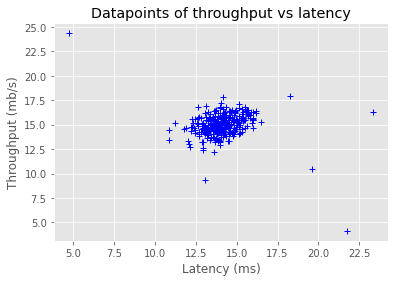

In [5]:
# Let us visualize our data
plt.figure(1)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Datapoints of throughput vs latency')
plt.plot(train_data[:,0], train_data[:,1],'b+')
plt.show()

In [6]:
#define the parameter and estimate the Gaussian distribution
def estimate_gaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

#define the multivariate Gaussian distribution
def multivariate_gaussian(dataset, mu, sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

In [9]:
mu, sigma = estimate_gaussian(train_data) #estimating the multivariate gaussian 
p = multivariate_gaussian(train_data,mu,sigma) # finding the probability density function for the dataset

In [12]:
print(mu) # this is vectoried implementation
print(sigma) # this is covariance matrix

[14.11225277 14.99767459]
[[ 1.83866684 -0.22783493]
 [-0.22783493  1.71530264]]


Let's define a function ϵ that will help us get the optimal value for the threshold which will be use to separate the normal and the anomalous datapoints. We are going to make use of the cross validation dataset to learn the optimal values of ϵ. To achieve this, we are going to try different values in a range of learned probabilities. We will then calculate the f1-score for the predicted anomalies based on the ground truth available data. The ϵ with the highest value of f1-score will be our threshold. This means that the probability that lie below the selected threshold will be considered anomalous.

In [8]:
def select_threshold(probs, test_data):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    # print(max(probs), min(probs), stepsize)
    epsilons = np.arange(min(probs), max(probs), stepsize)
    # print(epsilons)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        f = f1_score(test_data, predictions, average='binary')
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon

    return best_f1, best_epsilon

In [7]:
#selecting optimal value of epsilon using cross validation
p_cv = multivariate_gaussian(crossval_data,mu,sigma) # using the same mu and sigma and finding pdf for cross val dataset
fscore, ep = select_threshold(p_cv,test_data)
print(fscore, ep)

#selecting outlier datapoints
outliers = np.asarray(np.where(p < ep))

NameError: ignored

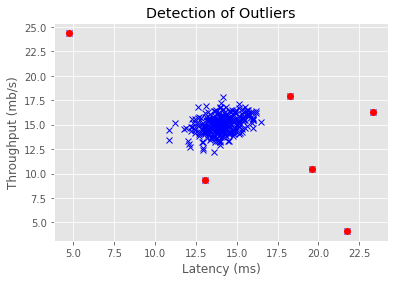

In [ ]:
# plotting our outliers
plt.figure(2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Detection of Outliers')
plt.plot(train_data[:,0],train_data[:,1],'bx')
plt.plot(train_data[outliers,0],train_data[outliers,1],'ro')
plt.show()

## Clustering based (KNN)

In [46]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [47]:
# import data
data = pd.read_csv("https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv")
# input data
df = data[["sepal_length", "sepal_width"]]

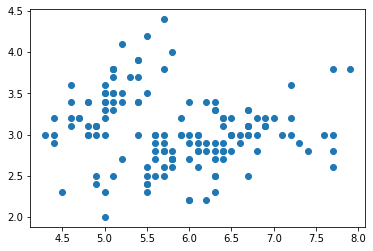

In [48]:
# scatterplot of inputs data
plt.scatter(df["sepal_length"], df["sepal_width"])

In [49]:
# create arrays
X = df.values

In [50]:
# KNN Modeling

# instantiate model
nbrs = NearestNeighbors(n_neighbors = 3)
# fit model
nbrs.fit(X)

NearestNeighbors(n_neighbors=3)

Now that we have fitted the model, it’s time to extract model outputs—(a) distances between data points and (b) associated index values — that can be used for detecting anomalies.

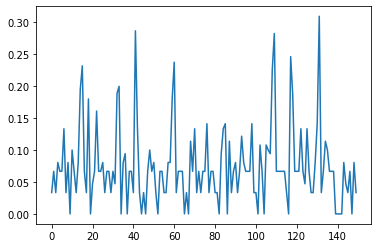

In [51]:
# distances and indexes of k-neaighbors from model outputs
distances, indexes = nbrs.kneighbors(X)
# plot mean of k-distances of each observation
plt.plot(distances.mean(axis =1))

As we can see, there are some spikes in distance measures, and these spikes are potentially anomalies or outliers in the dataset.

Now comes one of the most important decisions for data scientists — determining the cutoff value to filter anomalies.

As we see in the figure above, some cutoff possibilities are — 0.25, 0.20, 0.15 (y-axis), each filtering a progressively higher number of outliers.

For this demo, let’s be generous and choose 0.15 as the cutoff to get more outliers. The reason for being generous is to be able to further examine the data so we are not missing outlier.

In [52]:
# visually determine cutoff values > 0.15
outlier_index = np.where(distances.mean(axis = 1) > 0.15)
outlier_index

(array([ 14,  15,  18,  22,  32,  33,  41,  59,  60, 108, 109, 117, 118,
        131]),)

In [55]:
# filter outlier values
outlier_values = df.iloc[outlier_index]
outlier_values

,sepal_length,sepal_width
14,5.8,4.0
15,5.7,4.4
18,5.7,3.8
22,4.6,3.6
32,5.2,4.1
33,5.5,4.2
41,4.5,2.3
59,5.2,2.7
60,5.0,2.0
108,6.7,2.5


Plotting Anomalies

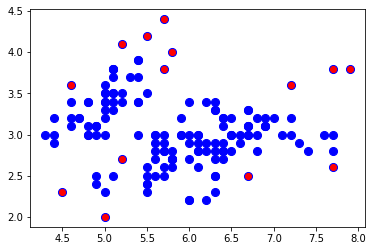

In [56]:
# plot data
plt.scatter(df["sepal_length"], df["sepal_width"], color = "b", s = 65)
# plot outlier values
plt.scatter(outlier_values["sepal_length"], outlier_values["sepal_width"], color = "r")